# **CricketDataAnalysis**

In [1]:
# Importing Libraries 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
# import tensorflow as tf
# from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ttest_ind
# from  import wrappers
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# from keras.layers import Dense
# from keras.models import Sequential

In [2]:
# Load the datasets
train_dataset_path = 'ball_by_ball_it20(train dataset).csv'
test_batting_dataset_path = 'LUMSU Cricket Dataset - Batting.csv'
test_bowling_dataset_path = 'LUMSU Cricket Dataset - Balling.csv'

train_dataset = pd.read_csv(train_dataset_path)
test_batting_dataset = pd.read_csv(test_batting_dataset_path)
test_bowling_dataset = pd.read_csv(test_bowling_dataset_path)

# print(train_dataset.shape)
# print(test_batting_dataset.shape)
# print(test_bowling_dataset.shape)

In [3]:
# print(train_dataset.columns.shape)

# Removing useless columns
columns_to_remove = ['Unnamed: 0','Date','Venue','Ball','Non Striker' ,'Ball Rebowled', 'Extra Type','Wicket','Runs to Get','Balls Remaining','Chased Successfully','Total Batter Runs','Total Non Striker Runs','Batter Balls Faced','Non Striker Balls Faced','Valid Ball']

train_dataset.drop(columns=columns_to_remove, axis=1, inplace=True)
# print(train_dataset.columns.shape)
# print(train_dataset.columns)

# print(train_dataset.shape)
# print(test_batting_dataset.shape)
# print(test_bowling_dataset.shape)

In [4]:
# Data Preprocessing
# Removing the null values


# train_dataset.dropna(inplace=True)
train_dataset.reset_index(drop=True, inplace=True)

# Removing the null values and resetting index for the test batting dataset
test_batting_dataset.dropna(inplace=True)
test_batting_dataset.reset_index(drop=True, inplace=True)

# Removing the null values and resetting index for the test bowling dataset
test_bowling_dataset.dropna(inplace=True)
test_bowling_dataset.reset_index(drop=True, inplace=True)


# print(train_dataset.shape)
# print(test_batting_dataset.shape)
# print(test_bowling_dataset.shape)


In [5]:
# Fill NaN values in 'Method' and 'Player Out' with 'Not Out'
train_dataset['Method'].fillna('Not Out', inplace=True)
train_dataset['Player Out'].fillna('Not Out', inplace=True)

# Fill NaN values in 'Player Out Runs' and 'Player Out Balls Faced' with 0
train_dataset['Player Out Runs'].fillna(0, inplace=True)
train_dataset['Player Out Balls Faced'].fillna(0, inplace=True)


In [6]:
train_dataset.head(5)

,Match ID,Bat First,Bat Second,Innings,Over,Batter,Bowler,Batter Runs,Extra Runs,Runs From Ball,Method,Player Out,Innings Runs,Innings Wickets,Target Score,Winner,Player Out Runs,Player Out Balls Faced,Bowler Runs Conceded
0,1339605,West Indies,South Africa,1,1,BA King,WD Parnell,1,0,1,Not Out,Not Out,1,0,259,South Africa,0.0,0.0,1
1,1339605,West Indies,South Africa,1,1,KR Mayers,WD Parnell,1,0,1,Not Out,Not Out,2,0,259,South Africa,0.0,0.0,1
2,1339605,West Indies,South Africa,1,1,BA King,WD Parnell,0,0,0,caught,BA King,2,1,259,South Africa,1.0,2.0,0
3,1339605,West Indies,South Africa,1,1,J Charles,WD Parnell,0,0,0,Not Out,Not Out,2,1,259,South Africa,0.0,0.0,0
4,1339605,West Indies,South Africa,1,1,J Charles,WD Parnell,4,0,4,Not Out,Not Out,6,1,259,South Africa,0.0,0.0,4


In [7]:
def function_make_batting_dataset(train_dataset, match_id, innings):
    # Filter data for the specific match and innings
    match_data = train_dataset[(train_dataset['Match ID'] == match_id) & (train_dataset['Innings'] == innings)]

    # Create a list of batters in the order they appear
    ordered_batters = match_data.drop_duplicates(subset='Batter', keep='first')['Batter'].tolist()

    # Aggregate batting data
    batting_data = match_data.groupby(['Batter']).agg(
        Runs=('Batter Runs', 'sum'),
        Balls_Played=('Batter', 'count'),
        How_Out=('Method', lambda x: x.iloc[-1])
    ).reset_index()

    # Determine batting position based on order of appearance
    batting_data['Batting_Position'] = batting_data['Batter'].apply(lambda x: ordered_batters.index(x) + 1)

    # Extract additional information
    batting_data['Team_Name'] = match_data['Bat First'].iloc[0] if innings == 1 else match_data['Bat Second'].iloc[0]
    batting_data['Bat_First'] = match_data['Bat First'].iloc[0]
    batting_data['Innings'] = innings
    batting_data['Target_Score'] = match_data['Target Score'].iloc[0]
    batting_data['Extra_Runs'] = match_data['Extra Runs'].sum()
    batting_data['Winner'] = match_data['Winner'].iloc[0]
    batting_data['Match_ID'] = match_id

    return batting_data


In [8]:
def function_make_bowling_dataset(train_dataset, match_id, innings):
    # Filter data for the specific match and innings
    match_data = train_dataset[(train_dataset['Match ID'] == match_id) & (train_dataset['Innings'] == innings)]

    # Aggregate bowling data
    bowling_data = match_data.groupby(['Bowler']).agg(
        Runs_Conceded=('Bowler Runs Conceded', 'sum'),
        Balls_Delivered=('Bowler', 'count'),
        Wickets=('Method', lambda x: (x != 'Not Out').sum())
    ).reset_index()

    # Extract additional information
    bowling_data['Team_Name'] = match_data['Bat Second'].iloc[0] if innings == 1 else match_data['Bat First'].iloc[0]
    bowling_data['Bat_First'] = match_data['Bat First'].iloc[0]
    bowling_data['Innings'] = innings
    bowling_data['Target_Score'] = match_data['Target Score'].iloc[0]
    bowling_data['Extra_Runs'] = match_data['Extra Runs'].sum()
    bowling_data['Winner'] = match_data['Winner'].iloc[0]
    bowling_data['Match_ID'] = match_id

    return bowling_data


In [9]:
unique_match_ids = train_dataset['Match ID'].unique()

# Initialize lists to store individual DataFrames
batting_data_frames = []
bowling_data_frames = []

for match_id in unique_match_ids:
    for innings in [1, 2]:
        batting_data = function_make_batting_dataset(train_dataset, match_id, innings)
        bowling_data = function_make_bowling_dataset(train_dataset, match_id, innings)

        # Store DataFrames in lists
        batting_data_frames.append(batting_data)
        bowling_data_frames.append(bowling_data)

# Concatenate all DataFrames in the lists
new_batting_dataset = pd.concat(batting_data_frames, ignore_index=True)
new_bowling_dataset = pd.concat(bowling_data_frames, ignore_index=True)


In [10]:
print(new_batting_dataset.shape)
print(new_bowling_dataset.shape)

new_batting_dataset.head(20)

(29507, 12)
(22039, 11)


,Batter,Runs,Balls_Played,How_Out,Batting_Position,Team_Name,Bat_First,Innings,Target_Score,Extra_Runs,Winner,Match_ID
0,BA King,1,2,caught,1,West Indies,West Indies,1,259,6,South Africa,1339605
1,J Charles,118,48,bowled,3,West Indies,West Indies,1,259,6,South Africa,1339605
2,KR Mayers,51,27,caught,2,West Indies,West Indies,1,259,6,South Africa,1339605
3,N Pooran,2,3,caught,4,West Indies,West Indies,1,259,6,South Africa,1339605
4,OF Smith,11,5,Not Out,7,West Indies,West Indies,1,259,6,South Africa,1339605
5,R Powell,28,20,caught,5,West Indies,West Indies,1,259,6,South Africa,1339605
6,R Shepherd,41,19,Not Out,6,West Indies,West Indies,1,259,6,South Africa,1339605
7,AK Markram,38,23,Not Out,5,South Africa,West Indies,2,259,11,South Africa,1339605
8,DA Miller,10,11,caught,4,South Africa,West Indies,2,259,11,South Africa,1339605
9,H Klaasen,16,7,Not Out,6,South Africa,West Indies,2,259,11,South Africa,1339605


In [11]:
new_bowling_dataset.head(20)

,Bowler,Runs_Conceded,Balls_Delivered,Wickets,Team_Name,Bat_First,Innings,Target_Score,Extra_Runs,Winner,Match_ID
0,AK Markram,22,13,0,South Africa,West Indies,1,259,6,South Africa,1339605
1,K Rabada,39,24,0,South Africa,West Indies,1,259,6,South Africa,1339605
2,M Jansen,52,25,3,South Africa,West Indies,1,259,6,South Africa,1339605
3,SSB Magala,67,24,0,South Africa,West Indies,1,259,6,South Africa,1339605
4,T Shamsi,33,12,0,South Africa,West Indies,1,259,6,South Africa,1339605
5,WD Parnell,43,26,2,South Africa,West Indies,1,259,6,South Africa,1339605
6,AJ Hosein,33,12,0,West Indies,West Indies,2,259,11,South Africa,1339605
7,JO Holder,48,24,1,West Indies,West Indies,2,259,11,South Africa,1339605
8,OF Smith,36,13,1,West Indies,West Indies,2,259,11,South Africa,1339605
9,R Powell,27,15,1,West Indies,West Indies,2,259,11,South Africa,1339605


In [12]:
# print(new_batting_dataset.columns)


# Handling null values for numeric columns - Replace with mean
numeric_cols = new_batting_dataset.select_dtypes(include=['float64', 'int64']).columns
new_batting_dataset[numeric_cols] = new_batting_dataset[numeric_cols].fillna(new_batting_dataset[numeric_cols].mean())

# For categorical/string columns, you can replace nulls with a placeholder or mode
# Example: new_batting_dataset['Batter'].fillna('Unknown', inplace=True)

# Convert categorical data to numeric - Mapping
how_out_mapping = {'bowled':1, 'caught':2,'lbw':3,'Not Out':4, 'retired out':5,'run out':6, 'stumped':7, 'caught and bowled':8, 'hit the ball twice':9, 'hit wicket':10, 'obstructing the field':11, 'retired hurt':12, 'retired not out':13}
new_batting_dataset['How_Out'] = new_batting_dataset['How_Out'].map(how_out_mapping)

# Rename columns to camel-case
new_batting_dataset.columns = ['batter', 'runs', 'ballsPlayed', 'howOut', 'battingPosition', 'teamName', 'batFirst', 'innings', 'targetScore', 'extraRuns', 'winner', 'matchId']

# Reset Index
new_batting_dataset.reset_index(drop=True, inplace=True)

# Convert float to int where applicable
new_batting_dataset['runs'] = new_batting_dataset['runs'].astype(int)
new_batting_dataset['ballsPlayed'] = new_batting_dataset['ballsPlayed'].astype(int)
# Additional conversions as needed

new_batting_dataset.drop(columns='innings', inplace=True)



In [13]:
new_batting_dataset.head(20)

,batter,runs,ballsPlayed,howOut,battingPosition,teamName,batFirst,targetScore,extraRuns,winner,matchId
0,BA King,1,2,2,1,West Indies,West Indies,259,6,South Africa,1339605
1,J Charles,118,48,1,3,West Indies,West Indies,259,6,South Africa,1339605
2,KR Mayers,51,27,2,2,West Indies,West Indies,259,6,South Africa,1339605
3,N Pooran,2,3,2,4,West Indies,West Indies,259,6,South Africa,1339605
4,OF Smith,11,5,4,7,West Indies,West Indies,259,6,South Africa,1339605
5,R Powell,28,20,2,5,West Indies,West Indies,259,6,South Africa,1339605
6,R Shepherd,41,19,4,6,West Indies,West Indies,259,6,South Africa,1339605
7,AK Markram,38,23,4,5,South Africa,West Indies,259,11,South Africa,1339605
8,DA Miller,10,11,2,4,South Africa,West Indies,259,11,South Africa,1339605
9,H Klaasen,16,7,4,6,South Africa,West Indies,259,11,South Africa,1339605


In [14]:
# Handling null values for numeric columns - Replace with mean
numeric_cols_bowling = new_bowling_dataset.select_dtypes(include=['float64', 'int64']).columns
new_bowling_dataset[numeric_cols_bowling] = new_bowling_dataset[numeric_cols_bowling].fillna(new_bowling_dataset[numeric_cols_bowling].mean())

# Reset Index
new_bowling_dataset.reset_index(drop=True, inplace=True)

# Rename columns to camel-case
new_bowling_dataset.columns = ['bowler', 'runsConceded', 'ballsDelivered', 'wickets', 'teamName', 'batFirst', 'innings', 'targetScore', 'extraRuns', 'winner', 'matchId']

# Convert float to int where applicable
new_bowling_dataset['runsConceded'] = new_bowling_dataset['runsConceded'].astype(int)
new_bowling_dataset['ballsDelivered'] = new_bowling_dataset['ballsDelivered'].astype(int)
new_bowling_dataset['wickets'] = new_bowling_dataset['wickets'].astype(int)

new_bowling_dataset.drop(columns=['innings','batFirst','extraRuns'], inplace=True)

In [15]:
new_bowling_dataset.head(20)

,bowler,runsConceded,ballsDelivered,wickets,teamName,targetScore,winner,matchId
0,AK Markram,22,13,0,South Africa,259,South Africa,1339605
1,K Rabada,39,24,0,South Africa,259,South Africa,1339605
2,M Jansen,52,25,3,South Africa,259,South Africa,1339605
3,SSB Magala,67,24,0,South Africa,259,South Africa,1339605
4,T Shamsi,33,12,0,South Africa,259,South Africa,1339605
5,WD Parnell,43,26,2,South Africa,259,South Africa,1339605
6,AJ Hosein,33,12,0,West Indies,259,South Africa,1339605
7,JO Holder,48,24,1,West Indies,259,South Africa,1339605
8,OF Smith,36,13,1,West Indies,259,South Africa,1339605
9,R Powell,27,15,1,West Indies,259,South Africa,1339605


In [16]:
# Cleaning Primary Batting Dataset

# Handling null values for numeric columns - Replace with mean
numeric_cols = test_batting_dataset.select_dtypes(include=['float64', 'int64']).columns
test_batting_dataset[numeric_cols] = test_batting_dataset[numeric_cols].fillna(test_batting_dataset[numeric_cols].mean())

# For categorical/string columns, you can replace nulls with a placeholder or mode
# Example: test_batting_dataset['Batter'].fillna('Unknown', inplace=True)

# Convert categorical data to numeric - Mapping
how_out_mapping = {'bowled':1, 'caught':2,'lbw':3,'not out':4, 'retired out':5,'run out':6, 'stumped':7}
test_batting_dataset['How Out'] = test_batting_dataset['How Out'].map(how_out_mapping)

# Rename columns to camel-case
test_batting_dataset.columns = ['matchId','batter', 'runs', 'ballsPlayed', 'howOut', 'battingPosition', 'captainName', 'winner', 'batFirst', 'extraRuns', 'targetScore']

# Reset Index
test_batting_dataset.reset_index(drop=True, inplace=True)

# Convert float to int where applicable
test_batting_dataset['runs'] = test_batting_dataset['runs'].astype(int)
test_batting_dataset['ballsPlayed'] = test_batting_dataset['ballsPlayed'].astype(int)

test_batting_dataset['batter'] = test_batting_dataset['batter'].str.capitalize()

In [17]:
# Cleaning Primary Bowling Dataset
test_bowling_dataset

# Handling null values for numeric columns - Replace with mean
numeric_cols_bowling = test_bowling_dataset.select_dtypes(include=['float64', 'int64']).columns
test_bowling_dataset[numeric_cols_bowling] = test_bowling_dataset[numeric_cols_bowling].fillna(test_bowling_dataset[numeric_cols_bowling].mean())

# Reset Index
test_bowling_dataset.reset_index(drop=True, inplace=True)

# Rename columns to camel-case
test_bowling_dataset.columns = ['matchId','bowler', 'runsConceded', 'ballsDelivered','foursConceded','sixConceded', 'wickets','winner', 'targetScore']

# Dropping rows containing '-' in any column
test_bowling_dataset = test_bowling_dataset[~test_bowling_dataset.isin(['-']).any(axis=1)]

# Resetting index after dropping rows
test_bowling_dataset.reset_index(drop=True, inplace=True)

test_bowling_dataset['bowler'] = test_bowling_dataset['bowler'].str.capitalize()

# We have 4 Major Datasets

### Train Batting

In [18]:
new_batting_dataset.head()

,batter,runs,ballsPlayed,howOut,battingPosition,teamName,batFirst,targetScore,extraRuns,winner,matchId
0,BA King,1,2,2,1,West Indies,West Indies,259,6,South Africa,1339605
1,J Charles,118,48,1,3,West Indies,West Indies,259,6,South Africa,1339605
2,KR Mayers,51,27,2,2,West Indies,West Indies,259,6,South Africa,1339605
3,N Pooran,2,3,2,4,West Indies,West Indies,259,6,South Africa,1339605
4,OF Smith,11,5,4,7,West Indies,West Indies,259,6,South Africa,1339605


### Train Bowling

In [19]:
new_bowling_dataset.head()

,bowler,runsConceded,ballsDelivered,wickets,teamName,targetScore,winner,matchId
0,AK Markram,22,13,0,South Africa,259,South Africa,1339605
1,K Rabada,39,24,0,South Africa,259,South Africa,1339605
2,M Jansen,52,25,3,South Africa,259,South Africa,1339605
3,SSB Magala,67,24,0,South Africa,259,South Africa,1339605
4,T Shamsi,33,12,0,South Africa,259,South Africa,1339605


### Primary Batting

In [20]:
test_batting_dataset.head()

,matchId,batter,runs,ballsPlayed,howOut,battingPosition,captainName,winner,batFirst,extraRuns,targetScore
0,1,Owais,10,11,2,1,Naimat (1),1,1,19,197
1,1,Adeen,6,8,2,2,Naimat,1,1,19,197
2,1,Ahmed,26,15,2,3,Naimat,1,1,19,197
3,1,Mustafa,4,5,2,4,Naimat,1,1,19,197
4,1,Moeez,18,29,2,5,Naimat,1,1,19,197


### Primary Bowling

In [21]:
test_bowling_dataset.head()

,matchId,bowler,runsConceded,ballsDelivered,foursConceded,sixConceded,wickets,winner,targetScore
0,1,Musab,40,24,5,1,0,1,197
1,1,Naimat,25,18,5,0,0,1,197
2,1,Jameel,26,18,6,0,1,1,197
3,1,Moiz,32,36,3,0,2,1,197
4,1,Hassan,12,18,1,0,0,1,197


## Q1 Is there a statistical association between a player's batting position and the likelihood of their dismissal?
Columns to consider: Batting Position, How Out

Violin plot: Frequency of each "How Out" type based on batting position

Bar plot: Frequency of each "How Out" type based on batting position 

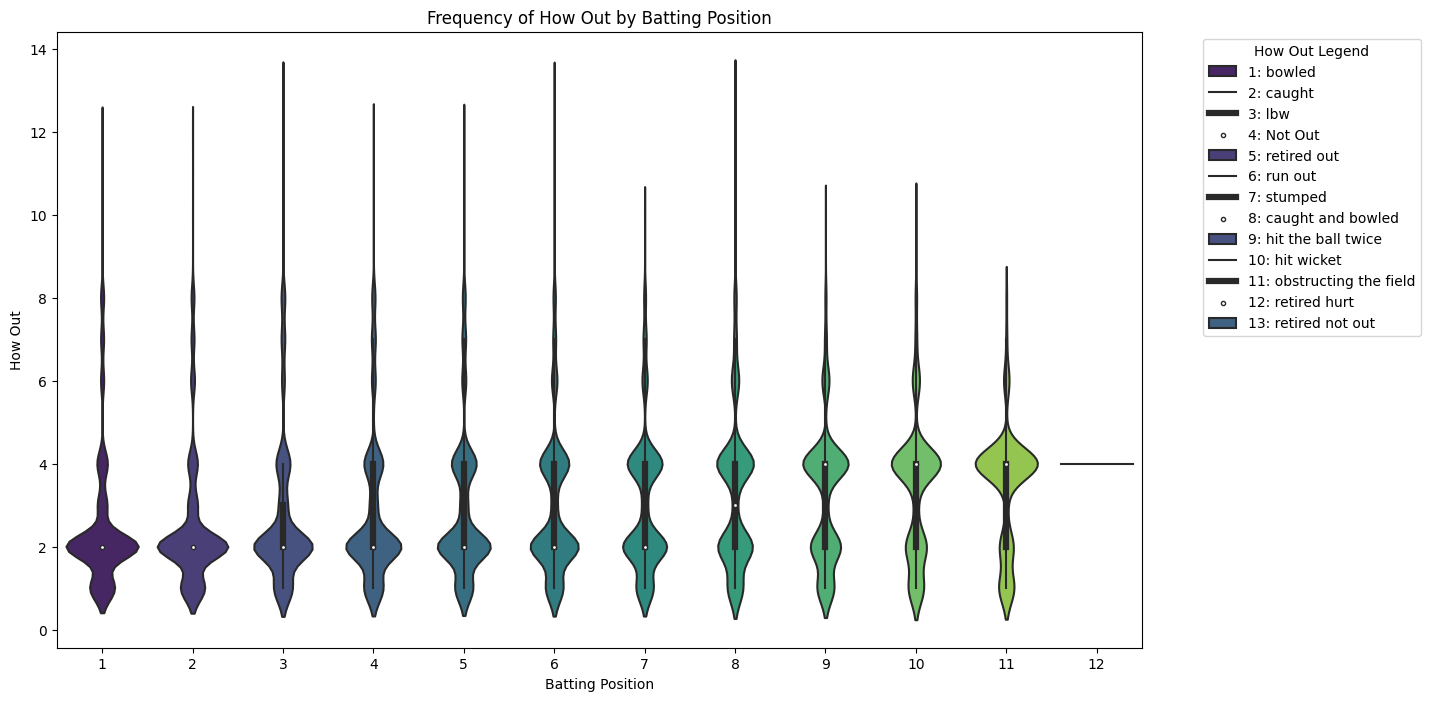

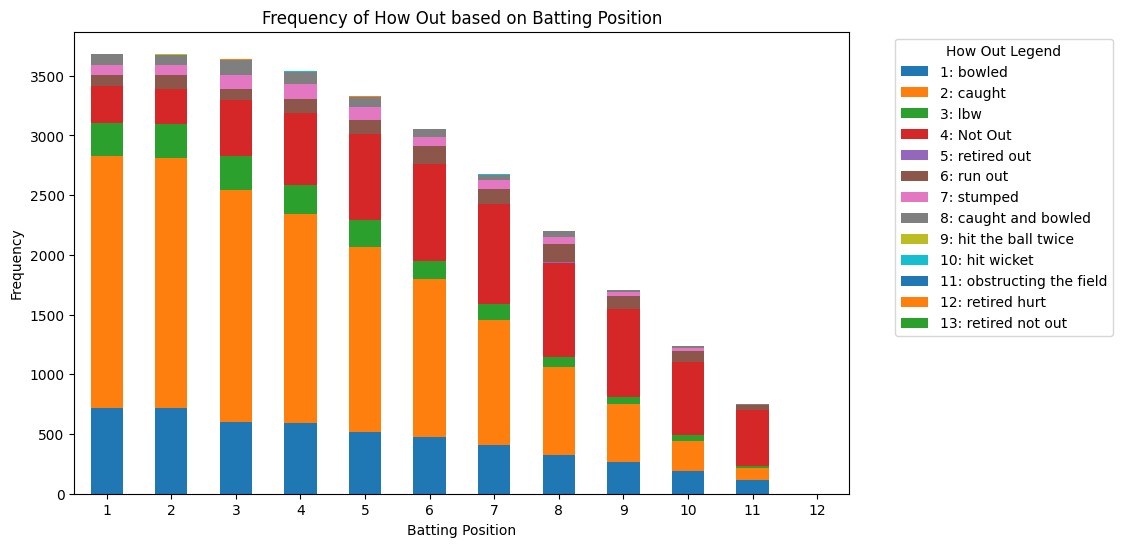

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your violin plot code
plt.figure(figsize=(14, 8))
sns.violinplot(x='battingPosition', y='howOut', data=new_batting_dataset, palette='viridis')
plt.title('Frequency of How Out by Batting Position')
plt.xlabel('Batting Position')
plt.ylabel('How Out')

how_out_mapping_reverse = {
    1: 'bowled', 2: 'caught', 3: 'lbw', 4: 'Not Out', 5: 'retired out',
    6: 'run out', 7: 'stumped', 8: 'caught and bowled', 9: 'hit the ball twice',
    10: 'hit wicket', 11: 'obstructing the field', 12: 'retired hurt', 13: 'retired not out'
}

legend_labels = [f'{key}: {value}' for key, value in how_out_mapping_reverse.items()]
plt.legend(labels=legend_labels, title='How Out Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()



grouped = new_batting_dataset.groupby(['battingPosition', 'howOut']).size().unstack()

# Plotting the stacked bar plot
grouped.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Batting Position')
plt.ylabel('Frequency')
plt.title('Frequency of How Out based on Batting Position')
# plt.legend(title='How Out')
plt.legend(labels=legend_labels, title='How Out Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=0)  # Ensure proper display of x-axis labels
plt.show()

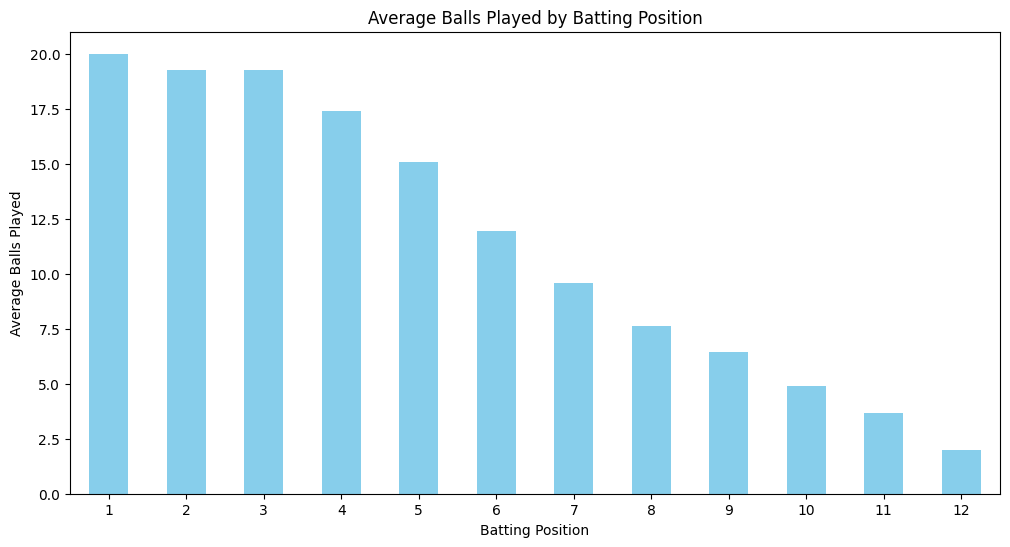

ATE_1: 0.16183570202274455
ATE_2: 0.1673879278381767
ATE_3: 0.1113426220932755
ATE_4: 0.0625994998036643
ATE_5: 0.007267861649127183
ATE_6: -0.04316568685832445
ATE_7: -0.09657513320797351
ATE_8: -0.14459153096326172
ATE_9: -0.21637645244085923
P-value for the treatment_1: 3.3760924444392293e-108
P-value for the treatment_2: 1.1870893344246995e-115
P-value for the treatment_3: 1.7052063835410607e-51
P-value for the treatment_4: 5.750886238002595e-17
P-value for the treatment_5: 0.34433529264126794
P-value for the treatment_6: 6.210317702742182e-08
P-value for the treatment_7: 3.279934563579466e-30
P-value for the treatment_8: 2.7054730232943555e-55
P-value for the treatment_9: 1.3193250434776048e-96
AdjustedATE_1: -0.14766272983923018
AdjustedATE_2: -0.1461216203438536
AdjustedATE_3: -0.1272285144834743
AdjustedATE_4: -0.08733120455784868
AdjustedATE_5: -0.05241959736426456
AdjustedATE_6: 0.00080524629495601
AdjustedATE_7: 0.05756260984823652
AdjustedATE_8: 0.08380357862942209
Adjusted

In [23]:
df=new_batting_dataset
plt.figure(figsize=(12, 6))
df.groupby('battingPosition')['ballsPlayed'].mean().plot(kind='bar', color='skyblue')
plt.title('Average Balls Played by Batting Position')
plt.xlabel('Batting Position')
plt.ylabel('Average Balls Played')
plt.xticks(rotation=0)
plt.show()
df['Dismissal']=df['howOut'].apply(lambda x: 0 if x==4 else 1)

for pos in range(1, 10):
    df[f'treatment_{pos}'] = (df['battingPosition'] == pos).astype(int)
# print(df)

# Calculate the Average Treatment Effect (ATE) for each batting position
ate_results = {}

for pos in range(1, 10):
    treatment_col = f'treatment_{pos}'
    ate = df.groupby(treatment_col)['Dismissal'].mean().diff().iloc[-1]
    # print(ate)
    ate_results[f'ATE_{pos}'] = ate

# Print ATE for each batting position
for pos, ate in ate_results.items():
    print(f"{pos}: {ate}")


# p-values
for pos in range(1, 10):
    outcome_variable = 'Dismissal'
    treatment_variable = f'treatment_{pos}'
    treatment_group = df[df[treatment_variable] == 1][outcome_variable]
    control_group = df[df[treatment_variable] == 0][outcome_variable]

    t_statistic, p_value = ttest_ind(treatment_group, control_group, equal_var=True)
    print(f"P-value for the treatment_{pos}: {p_value}")


df['ballsPlayed_25plus'] = (df['ballsPlayed'] >= 25).astype(int)

ate_results = {}
prob_1=(df[df['ballsPlayed_25plus']==1].count()['howOut'])/(df.count()['howOut'])
prob_0=1-prob_1
for pos in range(1, 10):
    treatment_col = f'treatment_{pos}'
    
    # Calculate ATE for players with similar numbers of balls played
    treated_group_1 = df[(df[treatment_col] == 1) & (df['ballsPlayed_25plus'] == 1)]
    untreated_group_1 = df[(df[treatment_col] == 0) & (df['ballsPlayed_25plus'] == 1)]

    ate_1 = treated_group_1['Dismissal'].mean() - untreated_group_1['Dismissal'].mean()
    treated_group_0 = df[(df[treatment_col] == 1) & (df['ballsPlayed_25plus'] == 0)]
    untreated_group_0 = df[(df[treatment_col] == 0) & (df['ballsPlayed_25plus'] == 0)]

    ate_0 = treated_group_0['Dismissal'].mean() - untreated_group_0['Dismissal'].mean()
    ate=ate_1*prob_1-ate_0*prob_0
    ate_results[f'AdjustedATE_{pos}'] = ate

# Print ATE for each batting position with balls played as a covariate
for pos, ate in ate_results.items():
    print(f"{pos}: {ate}")

In [24]:
import pandas as pd
from scipy.stats import chi2_contingency

# Assuming 'new_batting_dataset' is your DataFrame and it's already loaded

# Create a contingency table
contingency_table = pd.crosstab(new_batting_dataset['battingPosition'], new_batting_dataset['howOut'])

# Perform the Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Interpret the p-value
alpha = 0.05  # or 0.01 for a more stringent test
print(f"Chi-squared: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p}")

if p < alpha:
    print("There is a statistical association between batting position and likelihood of dismissal (reject H0)")
else:
    print("There is no statistical association between batting position and likelihood of dismissal (fail to reject H0)")

Chi-squared: 3753.283825914684
Degrees of freedom: 132
p-value: 0.0
There is a statistical association between batting position and likelihood of dismissal (reject H0)


## Q2 What is the distribution of dismissal types for top-scoring batsmen?
Columns to consider: Player_Name, Runs, How Out
Plots:

- Pie chart: Distribution of "How Out" types for top-scoring batsmen

- Bar plot: How Out types for players scoring above a certain threshold


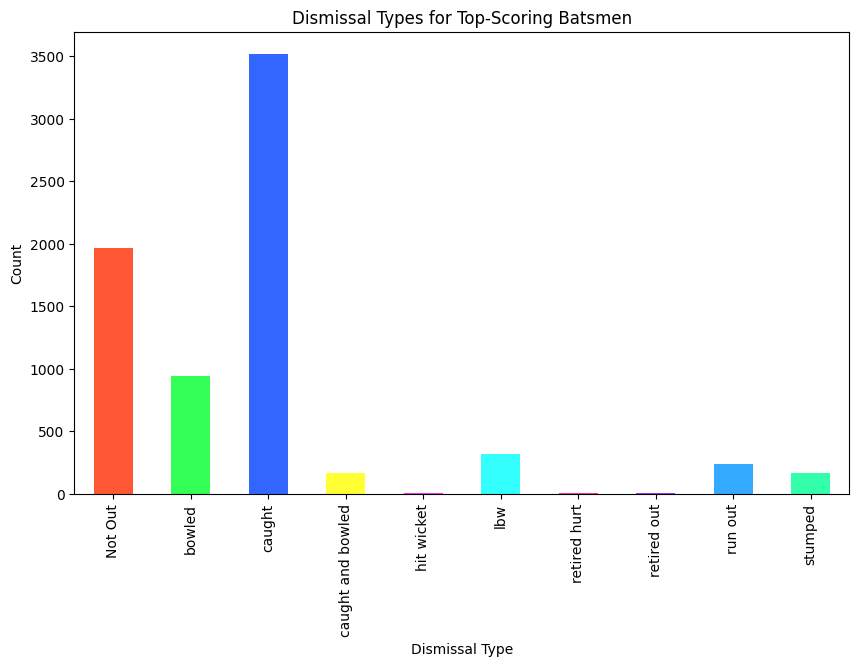

In [25]:
import matplotlib.pyplot as plt

# Filter top-scoring batsmen by taking out the top 25%
top_scorers = new_batting_dataset[new_batting_dataset['runs'] > new_batting_dataset['runs'].quantile(0.75)]

### We could also have stored the batsman who scored greater than a set threshold
# threshold=50
# top_scorers = new_batting_dataset[new_batting_dataset['runs'] > threshold]  


# Map numerical codes to dismissal types
how_out_mapping_reverse = {
    1: 'bowled', 2: 'caught', 3: 'lbw', 4: 'Not Out', 5: 'retired out',
    6: 'run out', 7: 'stumped', 8: 'caught and bowled', 9: 'hit the ball twice',
    10: 'hit wicket', 11: 'obstructing the field', 12: 'retired hurt', 13: 'retired not out'
}

# Count occurrences of dismissal types for top-scorers
dismissal_counts = top_scorers['howOut'].map(how_out_mapping_reverse).value_counts().sort_index()
custom_colors = ['#FF5733', '#33FF57', '#3366FF', '#FFFF33', '#FF33FF', '#33FFFF', '#FF33AA', '#AA33FF', '#33AAFF', '#33FFAA', '#AAFF33', '#FFAA33', '#33AA66']

# Create a bar plot
plt.figure(figsize=(10, 6))
dismissal_counts.plot(kind='bar', color=custom_colors)
plt.title('Dismissal Types for Top-Scoring Batsmen')
plt.xlabel('Dismissal Type')
plt.ylabel('Count')

# Add legend using Matplotlib
legend_labels = [f'{key}: {value}' for key, value in how_out_mapping_reverse.items()]
plt.show()




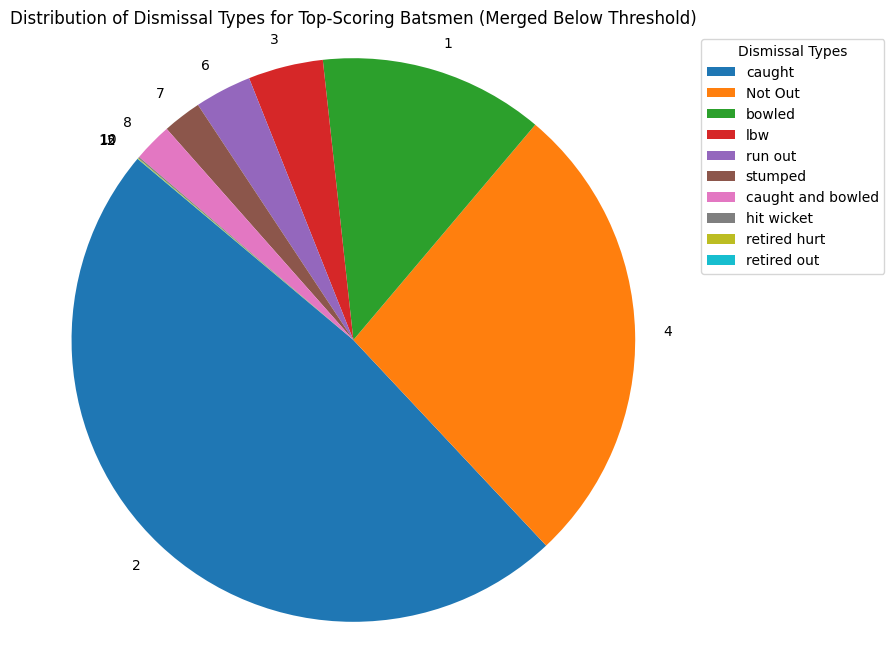

In [26]:
import matplotlib.pyplot as plt

# Make a copy of the DataFrame
modified_df = top_scorers.copy()

# Calculate the percentage of each dismissal type
dismissal_percentage = dismissal_counts / dismissal_counts.sum() * 100

# Set a threshold percentage (e.g., 3%)
threshold = 3

# Merge categories below the threshold into a new category 'Other'
categories_to_merge = dismissal_percentage[dismissal_percentage < threshold].index
modified_df['howOut'] = modified_df['howOut'].map(lambda x: 'Other' if x in categories_to_merge else x)

# Calculate dismissal counts for the modified DataFrame
dismissal_counts_modified = modified_df['howOut'].value_counts()

# Create legend labels using the reversed mapping
how_out_mapping = {
    'bowled': 1, 'caught': 2, 'lbw': 3, 'Not Out': 4, 'retired out': 5,
    'run out': 6, 'stumped': 7, 'caught and bowled': 8, 'hit the ball twice': 9,
    'hit wicket': 10, 'obstructing the field': 11, 'retired hurt': 12, 'retired not out': 13,
    'Other (Merged Below Threshold)': 'Other'
}

# Reverse the mapping for legend labels
how_out_mapping_reverse = {v: k for k, v in how_out_mapping.items()}

# Pie chart for dismissal types after merging below threshold
plt.figure(figsize=(8, 8))
plt.pie(dismissal_counts_modified, labels=dismissal_counts_modified.index, startangle=140)
plt.title('Distribution of Dismissal Types for Top-Scoring Batsmen (Merged Below Threshold)')
plt.axis('equal')

# Create legend labels using the modified reversed mapping
legend_labels = [how_out_mapping_reverse[label] for label in dismissal_counts_modified.index]
plt.legend(legend_labels, title='Dismissal Types', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [27]:
df1=new_batting_dataset
df1['topscorer']=df1['runs'].apply(lambda x: 1 if x>=28 else 0)
df1['caught']=df1['howOut'].apply(lambda x: 1 if x==2 else 0)
treatment_col = 'caught'
ate = df1.groupby(treatment_col)['topscorer'].mean().diff().iloc[1]

outcome_variable = 'caught'
treatment_variable = 'topscorer'
treatment_group = df1[df1[treatment_variable] == 1][outcome_variable]
control_group = df1[df1[treatment_variable] == 0][outcome_variable]

t_statistic, p_value = ttest_ind(treatment_group, control_group, equal_var=True)
print(f"P-value: {p_value}")

if p_value > 0:
    print("Top-scoring batsmen tend to have a higher average dismissal type compared to non-top-scorers.")
elif p_value < 0:
    print("Top-scoring batsmen have a lower average dismissal type compared to non-top-scorers.")
else:
    print("There is no difference in the average dismissal type between top-scorers and non-top-scorers.")
print("\n")

print(f"ATE: {ate}")
df1['ballsPlayed_20plus'] = (df1['ballsPlayed'] >= 20).astype(int)
prob_1=(df1[df1['ballsPlayed_20plus']==1].count()['howOut'])/(df1.count()['howOut'])
prob_0=1-prob_1
    # Calculate ATE for players with similar numbers of balls played
treated_group_1 = df1[(df1[treatment_col] == 1) & (df1['ballsPlayed_20plus'] == 1)]
untreated_group_1 = df1[(df1[treatment_col] == 0) & (df1['ballsPlayed_20plus'] == 1)]

ate_1 = treated_group_1['topscorer'].mean() - untreated_group_1['topscorer'].mean()
treated_group_0 = df1[(df1[treatment_col] == 1) & (df1['ballsPlayed_20plus'] == 0)]
untreated_group_0 = df1[(df1[treatment_col] == 0) & (df1['ballsPlayed_20plus'] == 0)]

ate_0 = treated_group_0['topscorer'].mean() - untreated_group_0['topscorer'].mean()
adj_ate=ate_1*prob_1-ate_0*prob_0
print(f"Conditioned on ballsPlayed ATE: {adj_ate}")

df1['target']=df1['targetScore'].apply(lambda x: 1 if x>=160 else 0)
prob_1=(df1[df1['target']==1].count()['howOut'])/(df1.count()['howOut'])
prob_0=1-prob_1
treated_group_1 = df1[(df1[treatment_col] == 1) & (df1['target'] == 1)]
untreated_group_1 = df1[(df1[treatment_col] == 0) & (df1['target'] == 1)]

ate_1 = treated_group_1['topscorer'].mean() - untreated_group_1['topscorer'].mean()
treated_group_0 = df1[(df1[treatment_col] == 1) & (df1['target'] == 0)]
untreated_group_0 = df1[(df1[treatment_col] == 0) & (df1['target'] == 0)]

ate_0 = treated_group_0['topscorer'].mean() - untreated_group_0['topscorer'].mean()
adj_ate=ate_1*prob_1-ate_0*prob_0
print(f"Conditioned on targetScore ATE: {adj_ate}")


P-value: 0.0035246121318336225
Top-scoring batsmen tend to have a higher average dismissal type compared to non-top-scorers.


ATE: 0.013748191496981005
Conditioned on ballsPlayed ATE: -0.008688888694716498
Conditioned on targetScore ATE: 0.021368954211875908


In [28]:
cond_ATE=0
for f in df1['target'].unique():
        for s in df1['ballsPlayed_20plus'].unique():
            t_rate = df1[(df1['target'] == f) & (df1['ballsPlayed_20plus'] == s)  & (df1[treatment_col] == 1)]['topscorer'].mean()
            c_rate = df1[(df1['target'] == f) & (df1['ballsPlayed_20plus'] == s)  & (df1[treatment_col] == 0)]['topscorer'].mean()

            estimated_ATE = t_rate - c_rate  
            prob = len(df1[(df1['target'] == f) & (df1['ballsPlayed_20plus'] == s) ])/len(df1)

            cond_ATE += estimated_ATE * prob
print(f"Conditioned on targetScore and ballsPlayed ATE: {cond_ATE}")

Conditioned on targetScore and ballsPlayed ATE: -0.015304130900699878


## Can we leverage machine learning to predict a player's future batting performance based on their historical performance in similar batting positions?

Columns to consider: Batting Position, Runs

- Line plot: Runs trend in various batting positions for individual players

#### We are currently just using the players from the Australia's Team


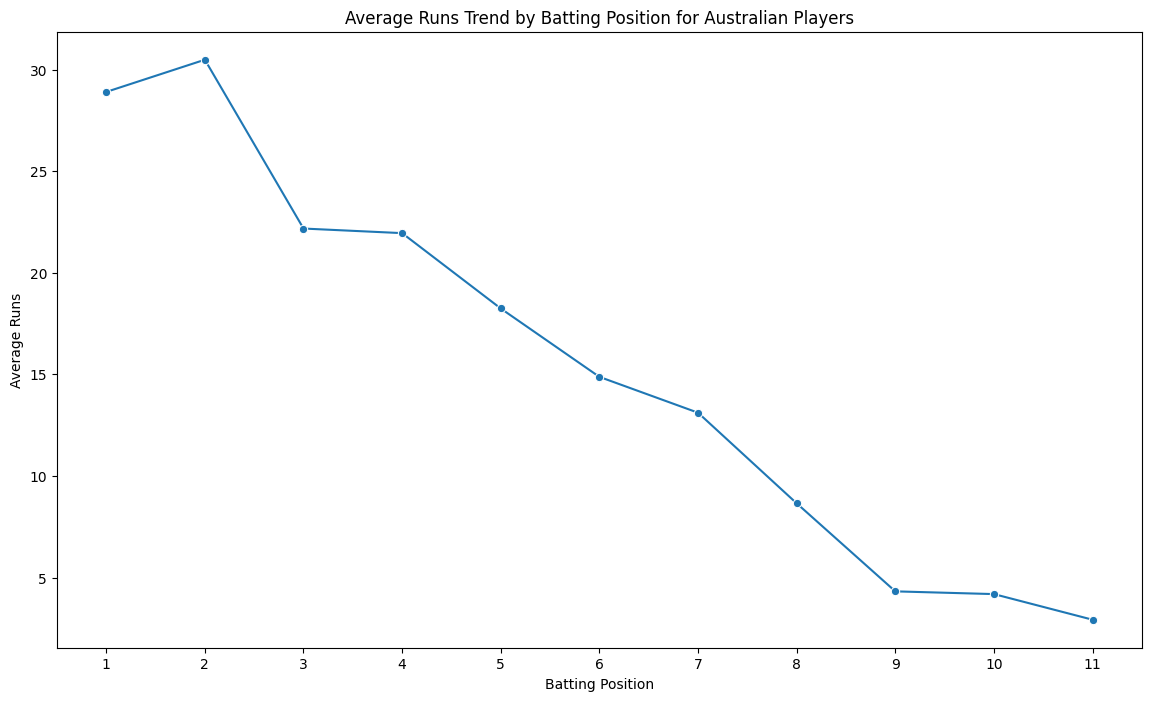

In [29]:
df=new_batting_dataset

# print(df.columns)

plt.figure(figsize=(14, 8))

# Calculate the average runs per batting position for the Australian team
average_runs_by_position = df[df['teamName'] == 'Australia'].groupby('battingPosition')['runs'].mean().reset_index()

sns.lineplot(x='battingPosition', y='runs', data=average_runs_by_position, marker='o')
plt.title('Average Runs Trend by Batting Position for Australian Players')
plt.xlabel('Batting Position')
plt.ylabel('Average Runs')
plt.xticks(range(1, 12))
plt.show()


In [30]:
df.head()

,batter,runs,ballsPlayed,howOut,battingPosition,teamName,batFirst,targetScore,extraRuns,winner,...,treatment_5,treatment_6,treatment_7,treatment_8,treatment_9,ballsPlayed_25plus,topscorer,caught,ballsPlayed_20plus,target
0,BA King,1,2,2,1,West Indies,West Indies,259,6,South Africa,...,0,0,0,0,0,0,0,1,0,1
1,J Charles,118,48,1,3,West Indies,West Indies,259,6,South Africa,...,0,0,0,0,0,1,1,0,1,1
2,KR Mayers,51,27,2,2,West Indies,West Indies,259,6,South Africa,...,0,0,0,0,0,1,1,1,1,1
3,N Pooran,2,3,2,4,West Indies,West Indies,259,6,South Africa,...,0,0,0,0,0,0,0,1,0,1
4,OF Smith,11,5,4,7,West Indies,West Indies,259,6,South Africa,...,0,0,1,0,0,0,0,0,0,1


In [31]:
# Get the number of unique team names
unique_teams = df['teamName'].nunique()
print(f"Number of unique teams: {unique_teams}")

# To see the list of unique team names
unique_team_names = df['teamName'].unique()
print(f"Unique team names: {unique_team_names}")

Number of unique teams: 97
Unique team names: ['West Indies' 'South Africa' 'Scotland' 'Bermuda' 'Estonia' 'Cyprus'
 'Portugal' 'Spain' 'Kuwait' 'Hong Kong' 'Sri Lanka' 'Ireland' 'Swaziland'
 'Seychelles' 'Belize' 'United States of America' 'England' 'Australia'
 'United Arab Emirates' 'Denmark' 'Italy' 'Bangladesh' 'Pakistan'
 'Finland' 'Sweden' 'India' 'Papua New Guinea' 'Afghanistan' 'Zimbabwe'
 'Japan' 'Vanuatu' 'Croatia' 'Netherlands' 'New Zealand' 'Romania'
 'Czech Republic' 'ICC World XI' 'Gibraltar' 'Rwanda' 'Malaysia'
 'Singapore' 'Bulgaria' 'Malta' 'Switzerland' 'Serbia' 'Nepal' 'Austria'
 'Germany' 'Samoa' 'Nigeria' 'Eswatini' 'Belgium' 'Oman' 'Bahamas'
 'Argentina' 'Ghana' 'Jersey' 'Panama' 'Hungary' 'Isle of Man' 'Kenya'
 'Uganda' 'China' 'Botswana' 'Qatar' 'Cayman Islands' 'Philippines'
 'Bahrain' 'Saudi Arabia' 'Malawi' 'Lesotho' 'Cameroon' 'Norway'
 'Guernsey' 'South Korea' 'Luxembourg' 'Maldives' 'Canada' 'St Helena'
 'Tanzania' 'Greece' 'Namibia' 'Thailand' 'Mali' 'Si

In [32]:
# Here's how you can calculate the number of unique matchIds for each teamName

unique_matchid_per_team = df.groupby('teamName')['matchId'].nunique().reset_index()
unique_matchid_per_team.columns = ['teamName', 'uniqueMatchIdCount']
print(unique_matchid_per_team)


                    teamName  uniqueMatchIdCount
0                Afghanistan                 109
1                  Argentina                  10
2                  Australia                 164
3                    Austria                  22
4                    Bahamas                   9
..                       ...                 ...
92      United Arab Emirates                  70
93  United States of America                  17
94                   Vanuatu                  20
95               West Indies                 168
96                  Zimbabwe                 115

[97 rows x 2 columns]


In [33]:
# Calculate the number of unique match IDs for each team
unique_matches_per_team = df.groupby('teamName')['matchId'].nunique().reset_index()
unique_matches_per_team.rename(columns={'matchId': 'uniqueMatchIdCount'}, inplace=True)

# Filter for teams with more than 20 unique match IDs
teams_with_more_than_50 = unique_matches_per_team[unique_matches_per_team['uniqueMatchIdCount'] > 50]

# Get the names of these teams
team_names_more_than_50 = teams_with_more_than_50['teamName'].tolist()

team_names_more_than_50

['Afghanistan',
 'Australia',
 'Bangladesh',
 'England',
 'Hong Kong',
 'India',
 'Ireland',
 'Kenya',
 'Nepal',
 'Netherlands',
 'New Zealand',
 'Pakistan',
 'Scotland',
 'South Africa',
 'Sri Lanka',
 'Uganda',
 'United Arab Emirates',
 'West Indies',
 'Zimbabwe']

In [34]:
# Initialize an empty dictionary to store the team names and match IDs
team_matches_dict = {}

# Loop over each team name that has more than 50 match IDs
for team in team_names_more_than_50:
    # Filter the DataFrame for the current team and get all unique match IDs
    match_ids = df[df['teamName'] == team]['matchId'].unique().tolist()
    # Add to the dictionary
    team_matches_dict[team] = match_ids

# Now `team_matches_dict` contains each team and its associated match IDs

print(team_matches_dict)

{'Afghanistan': [875545, 953345, 1273735, 1145982, 951315, 1327271, 1362817, 951335, 966713, 1310948, 1089778, 1074962, 1074958, 1134032, 533277, 662387, 1273738, 1072208, 546418, 951343, 1362816, 412687, 1145983, 1150144, 546443, 660123, 1307161, 1357694, 1193494, 1299832, 875467, 1040485, 1273744, 657631, 1252058, 1150143, 1145984, 1377015, 439495, 1040489, 412679, 1074969, 875485, 924639, 1252059, 1197141, 1298166, 1299833, 951365, 1193495, 1357695, 1273728, 682897, 1307160, 1197142, 1327279, 1074971, 1040487, 1307159, 1252060, 1193496, 1357696, 660203, 1307163, 951307, 1168112, 930585, 592273, 660235, 1327275, 439511, 966737, 439507, 875541, 1377016, 592272, 951351, 1168113, 1307162, 1298148, 924637, 662383, 682905, 1327278, 966741, 1273751, 660107, 1298172, 682913, 1168114, 1089776, 1362815, 1310946, 875551, 1072207, 953347, 1197144, 1327269, 1134031, 533274, 951321, 875459, 1216416, 1216417, 546477, 1197145, 1072206, 1310947, 1089777], 'Australia': [1072317, 647247, 412700, 13174

In [35]:
# Extract all match IDs from the dictionary
all_match_ids = []
for match_ids in team_matches_dict.values():
    all_match_ids.extend(match_ids)

# Filter the original DataFrame to include only rows with match IDs in all_match_ids
filtered_df = df[df['matchId'].isin(all_match_ids)]

# Now, filtered_df contains only the rows with match IDs present in team_matches_dict

print(df.shape)
print(filtered_df.shape)

(29507, 26)
(20589, 26)


In [36]:
split_ratio = 0.7  # 70% for training, 30% for testing

# Initialize empty DataFrames for training and testing datasets
train_df = pd.DataFrame()
test_df = pd.DataFrame()

# Iterate over each team and its match IDs in the dictionary
for team, match_ids in team_matches_dict.items():
    # Filter the main DataFrame for the current team
    team_data = filtered_df[filtered_df['teamName'] == team]

    # Split match IDs into approximately 70% for training and 30% for testing
    train_match_ids = match_ids[:int(split_ratio * len(match_ids))]
    test_match_ids = match_ids[int(split_ratio * len(match_ids)):]

    # Filter team_data for training and testing match IDs
    train_team_data = team_data[team_data['matchId'].isin(train_match_ids)]
    test_team_data = team_data[team_data['matchId'].isin(test_match_ids)]

    # Append the team-specific splits to the main training and testing DataFrames
    train_df = pd.concat([train_df, train_team_data])
    test_df = pd.concat([test_df, test_team_data])

# Reset index for both training and testing datasets
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)


In [37]:
print("Testing for Australia")
print(filtered_df[filtered_df["teamName"] == 'Australia'].shape)
print(train_df[train_df["teamName"] == 'Australia'].shape)
print(test_df[test_df["teamName"] == 'Australia'].shape)
print("Testing for England")
print(filtered_df[filtered_df["teamName"] == 'England'].shape)
print(train_df[train_df["teamName"] == 'England'].shape)
print(test_df[test_df["teamName"] == 'England'].shape)


Testing for Australia
(1239, 26)
(844, 26)
(395, 26)
Testing for England
(1277, 26)
(886, 26)
(391, 26)


In [38]:
train_df.head()

,batter,runs,ballsPlayed,howOut,battingPosition,teamName,batFirst,targetScore,extraRuns,winner,...,treatment_5,treatment_6,treatment_7,treatment_8,treatment_9,ballsPlayed_25plus,topscorer,caught,ballsPlayed_20plus,target
0,Asghar Stanikzai,22,30,7,2,Afghanistan,Papua New Guinea,128,10,Afghanistan,...,0,0,0,0,0,1,0,0,1,0
1,Mohammad Nabi,11,9,2,5,Afghanistan,Papua New Guinea,128,10,Afghanistan,...,1,0,0,0,0,0,0,1,0,0
2,Mohammad Shahzad,0,1,2,1,Afghanistan,Papua New Guinea,128,10,Afghanistan,...,0,0,0,0,0,0,0,1,0,0
3,Najibullah Zadran,14,6,4,6,Afghanistan,Papua New Guinea,128,10,Afghanistan,...,0,1,0,0,0,0,0,0,0,0
4,Nawroz Mangal,65,58,4,3,Afghanistan,Papua New Guinea,128,10,Afghanistan,...,0,0,0,0,0,1,1,0,1,0


In [39]:
test_df.head()

,batter,runs,ballsPlayed,howOut,battingPosition,teamName,batFirst,targetScore,extraRuns,winner,...,treatment_5,treatment_6,treatment_7,treatment_8,treatment_9,ballsPlayed_25plus,topscorer,caught,ballsPlayed_20plus,target
0,Amir Hamza,1,2,4,10,Afghanistan,England,143,6,England,...,0,0,0,0,0,0,0,0,0,0
1,Asghar Stanikzai,1,4,2,2,Afghanistan,England,143,6,England,...,0,0,0,0,0,0,0,1,0,0
2,Gulbadin Naib,0,5,2,4,Afghanistan,England,143,6,England,...,0,0,0,0,0,0,0,1,0,0
3,Mohammad Nabi,12,10,2,6,Afghanistan,England,143,6,England,...,0,1,0,0,0,0,0,1,0,0
4,Mohammad Shahzad,4,3,3,1,Afghanistan,England,143,6,England,...,0,0,0,0,0,0,0,0,0,0


## Q3 Batting Position Optimization: Analyze the effectiveness of different batting orders. You could explore questions like whether certain players perform better when they bat earlier or later in the lineup.  

In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Assuming train_df and test_df are already defined

# Step 1: Data Preprocessing
# Feature Engineering: Create new features based on historical performance

# Handling Categorical Data
categorical_features = ['batter', 'teamName']
numeric_features = ['ballsPlayed', 'targetScore', 'extraRuns']  # add more features as needed

# Pipeline for transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Step 2: Model Selection
model = RandomForestRegressor()

# Step 3: Model Training
X_train = preprocessor.fit_transform(train_df)
y_train = train_df['runs']
model.fit(X_train, y_train)

# Step 4: Model Evaluation
X_test = preprocessor.transform(test_df)
y_test = test_df['runs']
y_pred = model.predict(X_test)

# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  
print(f"Root Mean Squared Error: {rmse}")

# Step 5: Interpretation
# Analyze feature importances or use SHAP values for interpretation


Root Mean Squared Error: 7.07790861640895


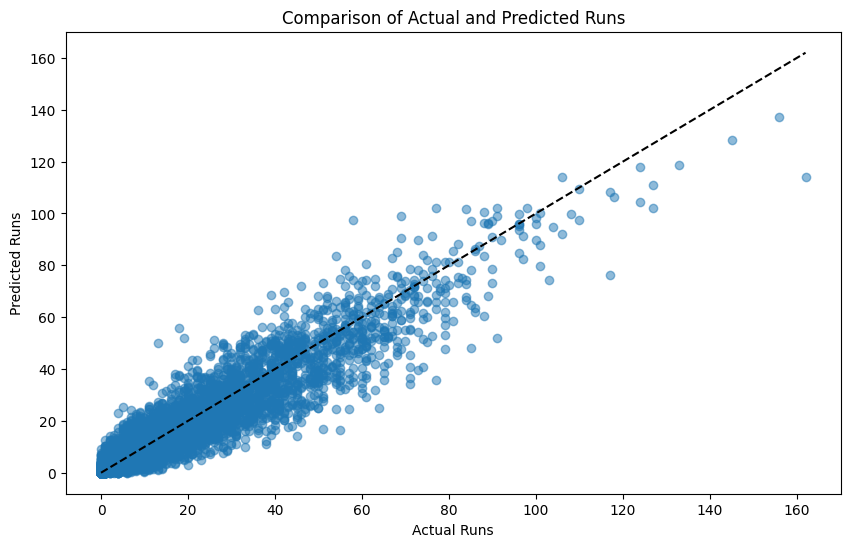

In [41]:
# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Runs")
plt.ylabel("Predicted Runs")
plt.title("Comparison of Actual and Predicted Runs")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # Diagonal line
plt.show()

Q3.2 Player Performance Analysis: Analyze individual player performances based on their batting position. For example, you can explore which players perform best in specific batting positions and under what match conditions.

In [42]:
from sklearn.model_selection import train_test_split

# Selecting features and target
features = ['batter', 'battingPosition', 'teamName', 'batFirst', 'targetScore', 'extraRuns']
target = 'runs'

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Handling categorical and numerical features
categorical_features = ['batter', 'teamName', 'batFirst']
numeric_features = ['battingPosition', 'targetScore', 'extraRuns']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Creating a pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Extracting features and target
X_train = train_df[features]
y_train = train_df[target]

# Training the model
model.fit(X_train, y_train)

# Preparing test data
X_test = test_df[features]
y_test = test_df[target]

# Making predictions
y_pred = model.predict(X_test)

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 18.625680436384435


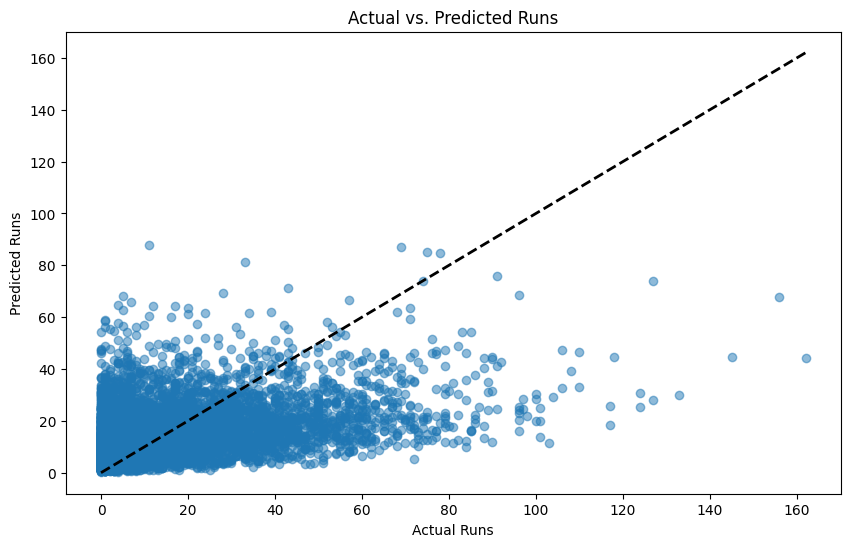

In [43]:
import matplotlib.pyplot as plt

# Scatter plot of Actual vs. Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Runs')
plt.xlabel('Actual Runs')
plt.ylabel('Predicted Runs')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.show()


In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import os
import joblib

# Create a directory to store models if it doesn't exist
models_directory = 'models'
if not os.path.exists(models_directory):
    os.makedirs(models_directory)

# Initialize a dictionary to store models for each team
models_by_team = {}

# Initialize a dictionary to store MAE for each team and batting position
mae_by_team_position = {}

# Iterate over unique teams
unique_teams = train_df['teamName'].unique()

for team in unique_teams:
    team_data = train_df[train_df['teamName'] == team]
    
    # Initialize a dictionary to store models for each batting position
    models_by_position = {}
    
    # Iterate over unique batting positions for the current team
    unique_positions = team_data['battingPosition'].unique()
    
    for position in unique_positions:
        # Select data for the current batting position and team
        position_data = team_data[team_data['battingPosition'] == position]
        
        # Features and target
        features = ['ballsPlayed', 'howOut']
        target = 'runs'
        
        X = position_data[features]
        y = position_data[target]
        
        # Initialize and train a Linear Regression model for the current position
        model = LinearRegression()
        model.fit(X, y)
        
        # Store the model for the current position
        models_by_position[position] = model
    
    # Store models for the current team
    models_by_team[team] = models_by_position

# Save models for each team using joblib
for team, models_by_position in models_by_team.items():
    team_model_filename = f"models/{team}_model.pkl"
    joblib.dump(models_by_position, team_model_filename)

# Later, to predict using the saved models on test_df and calculate MAE
for team, models_by_position in models_by_team.items():
    for position, model in models_by_position.items():
        # Select data for the current batting position and team from the test_df
        test_data = test_df[(test_df['teamName'] == team) & (test_df['battingPosition'] == position)]
        
        # Check if there are samples available for prediction
        if not test_data.empty:
            # Features for prediction
            X_test = test_data[features]
        
            # Predict runs using the loaded model
            predicted_runs = model.predict(X_test)
            
            # True runs from the test data
            true_runs = test_data['runs']
        
            # Calculate MAE
            mae = mean_absolute_error(true_runs, predicted_runs)
            
            # Store MAE for the current team and batting position
            if team not in mae_by_team_position:
                mae_by_team_position[team] = {}
            mae_by_team_position[team][position] = mae
            
            # Display predictions for the current team and batting position
            # print(f"Team: {team}, Batting Position: {position}")
            # print(f"Predicted runs: {(predicted_runs)}")
            # print(f"MAE: {mae}")
        else:
            # print(f"No data available for Team: {team}, Batting Position: {position} in the test data")
            pass

# Display MAE for each team and batting position
for team, positions in mae_by_team_position.items():
    for position, mae in positions.items():
        print(f"Team: {team}, Batting Position: {position}, MAE: {mae}")

from collections import defaultdict

# Dictionary to store aggregated MAEs for each batting position
aggregate_mae_by_position = defaultdict(list)

# Aggregate MAEs for each batting position across all teams
for team_mae in mae_by_team_position.values():
    for position, mae in team_mae.items():
        aggregate_mae_by_position[position].append(mae)

# Calculate the mean MAE for each batting position
mean_mae_by_position = {
    position: sum(maes) / len(maes)
    for position, maes in aggregate_mae_by_position.items()
}

# # Display the mean MAE for each batting position
# for position, mean_mae in mean_mae_by_position.items():
#     print(f"Batting Position: {position}, Mean MAE: {mean_mae}")





Team: Afghanistan, Batting Position: 2, MAE: 5.325502704598535
Team: Afghanistan, Batting Position: 5, MAE: 6.470117078691826
Team: Afghanistan, Batting Position: 1, MAE: 9.18759418210385
Team: Afghanistan, Batting Position: 6, MAE: 5.616957540335496
Team: Afghanistan, Batting Position: 3, MAE: 4.782273933125479
Team: Afghanistan, Batting Position: 4, MAE: 6.656538435996578
Team: Afghanistan, Batting Position: 8, MAE: 4.2349866978122614
Team: Afghanistan, Batting Position: 7, MAE: 6.040250190622454
Team: Afghanistan, Batting Position: 9, MAE: 2.9125505348372505
Team: Afghanistan, Batting Position: 11, MAE: 1.56575088286347
Team: Afghanistan, Batting Position: 10, MAE: 3.5627924844590333
Team: Australia, Batting Position: 7, MAE: 3.9005244378129174
Team: Australia, Batting Position: 2, MAE: 7.65415314531402
Team: Australia, Batting Position: 1, MAE: 6.049740195150969
Team: Australia, Batting Position: 4, MAE: 6.019030627045973
Team: Australia, Batting Position: 3, MAE: 4.409934695226267

In [45]:
print("Mean Absolute Error According to the Batting Position")

# Sort mean MAE by batting position
sorted_mean_mae_by_position = dict(sorted(mean_mae_by_position.items()))

# Display the sorted mean MAE for each batting position
for position, mean_mae in sorted_mean_mae_by_position.items():
    print(f"Batting Position: {position}, Mean MAE: {mean_mae}")


Mean Absolute Error According to the Batting Position
Batting Position: 1, Mean MAE: 5.911327801432854
Batting Position: 2, Mean MAE: 6.979674374573665
Batting Position: 3, Mean MAE: 5.781670585860926
Batting Position: 4, Mean MAE: 6.111822322377428
Batting Position: 5, Mean MAE: 5.460964272911102
Batting Position: 6, Mean MAE: 4.7568913369532
Batting Position: 7, Mean MAE: 4.088738309495207
Batting Position: 8, Mean MAE: 4.041105406375547
Batting Position: 9, Mean MAE: 2.9101951330719156
Batting Position: 10, Mean MAE: 2.3072504986336435
Batting Position: 11, Mean MAE: 1.7055256562256367


## TEST PRIMARY DATASET

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from collections import defaultdict

# Initialize a dictionary to store models for each batting position
models_by_position = {}

# Iterate over unique batting positions
unique_positions = test_batting_dataset['battingPosition'].unique()

for position in unique_positions:
    # Select data for the current batting position
    position_data = test_batting_dataset[test_batting_dataset['battingPosition'] == position]
    
    # Features and target
    features = ['ballsPlayed', 'howOut']
    target = 'runs'
    
    X = position_data[features]
    y = position_data[target]
    
    # Initialize and train a Linear Regression model for the current position
    model = LinearRegression()
    model.fit(X, y)
    
    # Store the model for the current position
    models_by_position[position] = model
    
print("LUMS CRICKET TEAM\n")

# Later, to test the models and calculate MAE
for position, model in models_by_position.items():
    # Select data for the current batting position
    position_data = test_batting_dataset[test_batting_dataset['battingPosition'] == position]
    
    # Features for prediction
    X_test = position_data[features]
    
    # Predict runs using the model
    predicted_runs = model.predict(X_test)
    
    # Display player name, team name, and the predicted score for each data point
    print(f"Position {position}")
    for index, (_, row) in enumerate(position_data.iterrows()):
        player_name = row['batter']
        player_batting_position = row['battingPosition']
        
        predicted_score = predicted_runs[index]
        print(f"{index+1} Player: {player_name}, Predicted Score: {int(predicted_score)}")
    print("\n")


LUMS CRICKET TEAM

Position 1
1 Player: Owais, Predicted Score: 13
2 Player: Mustafa, Predicted Score: 57
3 Player: Awais, Predicted Score: 13
4 Player: Umer, Predicted Score: 34
5 Player: Mustafa, Predicted Score: 58
6 Player: Adeen, Predicted Score: 45
7 Player: Adeen , Predicted Score: 3
8 Player: Mustafa, Predicted Score: 6
9 Player: Mustafa, Predicted Score: 1
10 Player: Sheheryar, Predicted Score: 5
11 Player: Imran, Predicted Score: 45
12 Player: Sheheryar, Predicted Score: 1
13 Player: Iftikhar, Predicted Score: 12
14 Player: Qaiser, Predicted Score: 0
15 Player: Imran, Predicted Score: 86
16 Player: Sheheryar, Predicted Score: 14
17 Player: Mahad, Predicted Score: 44
18 Player: Sherry, Predicted Score: 11
19 Player: Sheheryar, Predicted Score: 14
20 Player: Omar azeem, Predicted Score: 25
21 Player: Sheheryar, Predicted Score: 24


Position 2
1 Player: Adeen, Predicted Score: 10
2 Player: Adeen, Predicted Score: 52
3 Player: Yahya, Predicted Score: 77
4 Player: Saroya, Predict

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from collections import defaultdict


# Initialize a dictionary to store models for each batting position
models_by_position = {}

# Iterate over unique batting positions
unique_positions = test_batting_dataset['battingPosition'].unique()

for position in unique_positions:
    # Select data for the current batting position
    position_data = test_batting_dataset[test_batting_dataset['battingPosition'] == position]
    
    # Features and target
    features = ['ballsPlayed', 'howOut']
    target = 'runs'
    
    X = position_data[features]
    y = position_data[target]
    
    # Initialize and train a Linear Regression model for the current position
    model = LinearRegression()
    model.fit(X, y)
    
    # Store the model for the current position
    models_by_position[position] = model

# Initialize a dictionary to store MAE for each batting position
mae_by_position = defaultdict(list)

# Later, to test the models and calculate MAE
for position, model in models_by_position.items():
    # Select data for the current batting position
    position_data = test_batting_dataset[test_batting_dataset['battingPosition'] == position]
    
    # Features for prediction
    X_test = position_data[features]
    
    # True runs from the data
    true_runs = position_data['runs']
    
    # Predict runs using the model
    predicted_runs = model.predict(X_test)
    
    # Calculate MAE
    mae = mean_absolute_error(true_runs, predicted_runs)
    
    # Store MAE for the current batting position
    mae_by_position[position] = mae


print("LUMS CRICKET TEAM")

# Display MAE for each batting position
for position, mae in mae_by_position.items():
    print(f"Batting Position: {position}, MAE: {mae}")


LUMS CRICKET TEAM
Batting Position: 1, MAE: 5.054679271712021
Batting Position: 2, MAE: 5.436286308322446
Batting Position: 3, MAE: 8.369722346935374
Batting Position: 4, MAE: 5.000281821614594
Batting Position: 5, MAE: 6.561773827166067
Batting Position: 6, MAE: 5.036658455482343
Batting Position: 7, MAE: 5.029386549605234
Batting Position: 8, MAE: 1.9015005733722874
Batting Position: 9, MAE: 1.2672256097560977
Batting Position: 10, MAE: 2.043124704894812
Batting Position: 11, MAE: 0.24999999999999997
